In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import jax.numpy as jnp
import jax.random as random
import optax
from jax import random
from numpyro.infer import Predictive
import numpyro

numpyro.set_host_device_count(4)

from reusable.data import gen_gp_batches
from reusable.gp import BuildGP
from reusable.kernels import esq_kernel
from reusable.loss import combo3_loss, combo_loss, MMD_rbf, RCL, KLD
from reusable.train_nn import SimpleTrainState, run_training_shuffle
from reusable.util import (
    save_args,
    save_training,
    setup_signals,
    gen_file_name,
    save_scores,
    get_decoder_params,
    save_datasets,
    load_datasets,
    load_training_state,
    save_samples,
)
from reusable.vae import VAE, vae_sample
from reusable.geo import load_state_centroids, centroids_to_coords, get_temp_data
from reusable.mcmc import vae_mcmc, run_mcmc
from reusable.scoring import calc_correlation_mats, calc_frob_norms, calc_mmd_scores, calc_moments
import numpy as onp

In [28]:


args = {
    # geographic data
    "state": 36,  # New York
    # ground truth
    "year": 2010,
    "coord_scaling_factor":  1e5,
    "aggr_method": "mean",
    # GP prior configuration
    "gp_kernel": esq_kernel,
    "rng_key": random.PRNGKey(2),
}

state_centroids = load_state_centroids(args["state"])
coords = centroids_to_coords(state_centroids, args["coord_scaling_factor"])

args.update(
    {  # so we can use the definition of n to define x
        "x": coords,
        "n": coords.shape[0],
        # VAE configuration
        "hidden_dim1": 630, # 0.35 * n 
        "hidden_dim2": 575,
        "latent_dim": 540,
        # learning
        "num_epochs": 50,
        "learning_rate": 1.0e-3,
        "batch_size": 400,
        "train_num_batches": 200,
        "test_num_batches": 2,
        "length_prior_choice": "invgamma",
        "length_prior_arguments": {"concentration": 4.0, "rate": 1.0},
        "variance_prior_choice": "gamma",
        "variance_prior_arguments": {"concentration": 5.25, "rate": 0.5},
        "scoring_num_draws": 2000,
        "expcode": "22",
        "loss_fns": [None, combo_loss(RCL, KLD), combo3_loss(RCL, KLD, MMD_rbf(4.0), 0.01, 1, 10)],
        
        # MCMC parameters
        "num_warmup": 20000,
        "num_samples": 20000,
        "thinning": 1,
        "num_chains": 4,
        "jitter_scaling": 1 / 300 * 4e-6,  # n times this gives the jitter
    }
)


ground_truth_df = get_temp_data(args["state"], args["year"], args["aggr_method"])

args["ground_truth"] = ground_truth_df["tmean"].to_numpy()

rng_key_ground_truth_obs_mask = random.PRNGKey(41234)


num_obs = int(args["n"] * 0.5)


obs_mask = jnp.concatenate((jnp.full((num_obs), True), jnp.full((args["n"]-num_obs), False)))
obs_mask = random.permutation(rng_key_ground_truth_obs_mask, obs_mask)

args["obs_idx"] =  jnp.array([x for x in range(args["n"]) if obs_mask[x]==True])

args["ground_truth_y_obs"] = args["ground_truth"][args["obs_idx"]]




args["loss_fn_names"] = ["gp" if x is None else x.__name__ for x in args["loss_fns"]]


rng_key, _ = random.split(random.PRNGKey(4))


rng_key, rng_key_train, rng_key_test = random.split(rng_key, 3)

gp = BuildGP(
    args["gp_kernel"],
    noise=False,
    length_prior_choice=args["length_prior_choice"],
    length_prior_args=args["length_prior_arguments"],
    variance_prior_choice=args["variance_prior_choice"],
    variance_prior_args=args["variance_prior_arguments"],
)


Mean 10.5 Variance 21.0


In [30]:
coords

Array([[ 2.978005 , -0.29035  ],
       [ 1.45952  , -1.41885  ],
       [ 1.48084  , -1.455125 ],
       ...,
       [-1.40634  , -0.581175 ],
       [-1.3265375, -0.62581  ],
       [-1.3687875, -0.615285 ]], dtype=float32)

Mean: 0.3387386202812195, Variance: 114.9616470336914


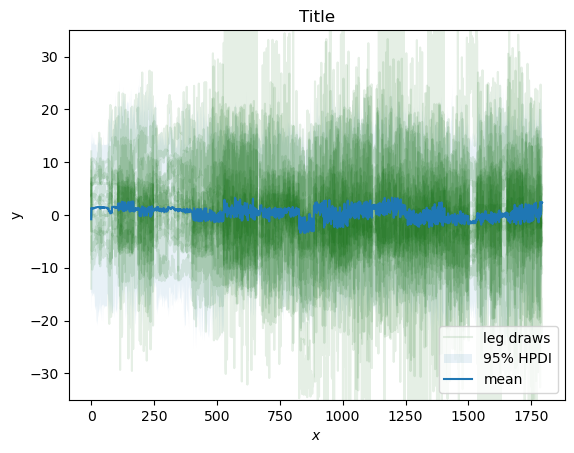

In [29]:
pred = Predictive(gp, num_samples=100)

samplesA = pred(rng_key_train, x=args["x"], gp_kernel=args["gp_kernel"], jitter=2e-6)["y"]
from plotting.plots import plot_draws, plot_draws_hpdi

plot_draws_hpdi(samplesA, jnp.arange(args["n"]), "Title", "y", "leg",  _min=-35, _max=35)

print(f"Mean: {onp.mean(samplesA)}, Variance: {onp.var(samplesA)}")

Mean: 0.019884072244167328, Variance: 110.1388931274414


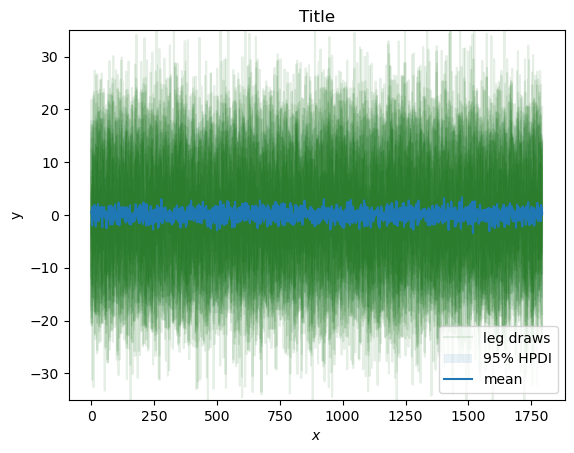

In [25]:
pred = Predictive(gp, num_samples=100)

samplesA = pred(rng_key_train, x=args["x"], gp_kernel=args["gp_kernel"], jitter=2e-6, var=10.5)["y"]
from plotting.plots import plot_draws, plot_draws_hpdi

plot_draws_hpdi(samplesA, jnp.arange(args["n"]), "Title", "y", "leg",  _min=-35, _max=35)





print(f"Mean: {onp.mean(samplesA)}, Variance: {onp.var(samplesA)}")

Mean (before centering): 9.922109445112588, Variance: 110.53613907926584


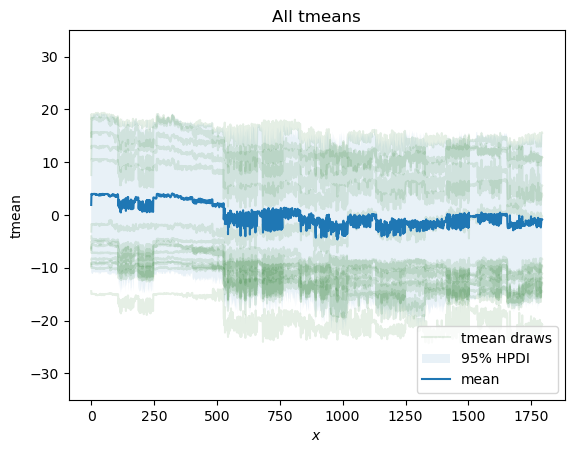

In [6]:
from reusable.geo import get_all_temp_data
from numpy.random import default_rng
import numpy as onp
rng = default_rng()

df = get_all_temp_data(args["state"], args["year"])
temps = df["tmean"].to_numpy()
mean = onp.mean(temps)
hpdi = numpyro.diagnostics.hpdi(temps - mean, 0.9)
s = temps.reshape((-1, 1794)) - mean
rng.shuffle(s)
plot_draws_hpdi(s, jnp.arange(args["n"]), "All tmeans", "tmean", "tmean", _min=-35, _max=35)
    

print(f"Mean (before centering): {mean}, Variance: {onp.var(temps)}")

In [7]:
df[df["date"]=="02/01/2010"]

,zcta,tmean,date,day,month,year
1794,06390,0.284636,02/01/2010,02,01,2010.0
1795,10001,1.424662,02/01/2010,02,01,2010.0
1796,10002,1.524563,02/01/2010,02,01,2010.0
1797,10003,1.424662,02/01/2010,02,01,2010.0
1798,10004,1.552776,02/01/2010,02,01,2010.0
...,...,...,...,...,...,...
3583,14898,-5.450043,02/01/2010,02,01,2010.0
3584,14901,-3.408991,02/01/2010,02,01,2010.0
3585,14903,-3.369193,02/01/2010,02,01,2010.0
3586,14904,-3.167674,02/01/2010,02,01,2010.0


In [8]:
temps.reshape((-1, 1794))[1]

array([ 0.28463601,  1.42466206,  1.52456334, ..., -3.36919271,
       -3.1676739 , -3.3249673 ])